In [1]:
from itertools import product
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import xarray as xr

In [2]:
SHOW_PLOTS = False  # Flag to control plot display
SAVE_PLOTS = True  # Flag to save generated plots

In [3]:
PROJECT_PATH = Path(".")

DATA_PATH = PROJECT_PATH / "data"
DATA_RAW_PATH = DATA_PATH / "01_raw"

IMG_PATH = PROJECT_PATH / "imgs"

CHLOROPHYLL_DATA_PATH = (
    DATA_RAW_PATH / "chl_cmems_obs-oc_glo_bgc-plankton_my_l4-gapfree-multi-4km_P1D.nc"
)

# Data Loading and Preprocessing

The dataset is loaded using xarray. Column names "longitude" and "latitude" are renamed to "lon" and "lat" respectively, simplifying variable access.

## Loading and Initial Inspection


In [4]:
ds = xr.open_dataset(CHLOROPHYLL_DATA_PATH, engine="netcdf4")
ds = ds.rename({"longitude": "lon", "latitude": "lat"})

lat_min, lat_max = float(ds.lat.min()), float(ds.lat.max())
lon_min, lon_max = float(ds.lon.min()), float(ds.lon.max())
boundaries = (lon_min, lat_min, lon_max, lat_max)
centroid = ((lat_min + lat_max) / 2, (lon_min + lon_max) / 2)

POI = LAT_POI, LON_POI = -23.627534, -70.396026

In [5]:
# Get the quantiles of chlorophyll-a concentration
q_01, q_99 = ds["CHL"].quantile([0.01, 0.99], method="closest_observation").values
print(f"Quantiles: {q_01 = :.2f}, {q_99 = :.2f}")

Quantiles: q_01 = 0.11, q_99 = 4.46


## Initial Visualisation

A preliminary visualization of the chlorophyll concentration across the dataset's spatial extent is performed.

In [6]:
from matplotlib.figure import Figure
from matplotlib.axes import Axes
from matplotlib.colors import Colormap


def plot_chlorophyll(
    ds: xr.Dataset,
    time_index: int,
    fig: Figure = None,
    ax: Axes = None,
    title: str | None = None,
    colorbar: bool = True,
    vmin: float = q_01,
    vmax: float = q_99,
    cmap: str | Colormap | None = None,
) -> tuple[Figure, Axes]:
    """
    Plot chlorophyll-a concentration from a dataset.

    :param ds: xarray dataset containing chlorophyll-a data.
    :param time_index: Index of the time dimension to plot. Must be an integer.
    :param fig: Matplotlib figure object. If None, a new figure is created.
    :param ax: Matplotlib axes object. If None, a new axes is created.
    :param title: Title of the plot. If None, a default title is generated.
    :param colorbar: Whether to display a colorbar. Default is True.
    :param vmin: Minimum value for color mapping. Default is the 1st percentile of chlorophyll-a data.
    :param vmax: Maximum value for color mapping. Default is the 99th percentile of chlorophyll-a data.
    :param cmap: Colormap to use for the plot. Default is "jet".
    :return: Tuple of the figure and axes objects.
    """

    if fig is None or ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))

    lat = ds.lat.data
    lon = ds.lon.data
    chl = ds.CHL.data

    pcolormesh_kwargs = dict(
        shading="auto", cmap=cmap or sns.color_palette("viridis", as_cmap=True)
    )

    pcolormesh_kwargs["vmin"] = vmin
    pcolormesh_kwargs["vmax"] = vmax

    mesh = ax.pcolormesh(lon, lat, chl[time_index, :, :], **pcolormesh_kwargs)

    # Plot the point of interest
    ax.plot(
        LON_POI,
        LAT_POI,
        marker="o",
        color="red",
        markersize=8,
        label="Point of Interest",
    )

    if colorbar:
        colorbar_kwargs = dict(ax=ax, label="Chlorophyll-a concentration (mg/m³)")

        colorbar_kwargs["extend"] = "both"
        cbar = fig.colorbar(mesh, **colorbar_kwargs)
        cbar.cmap.set_under("gray")
        cbar.cmap.set_over("magenta")

    title = (
        title
        or f"Chlorophyll-a concentration on {str(ds.time[time_index].values)[:10]}"
    )

    ax.set_title(title)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    ax.set_aspect("equal", adjustable="box")

    return fig, ax

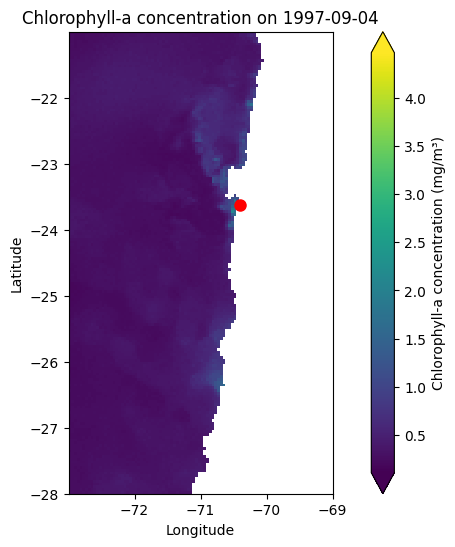

In [7]:
plot_chlorophyll(ds, 0)
plt.show()

## Research of Missing Values

The initial plot reveals a large, persistent region of missing values (likely land/coast). 

Google Earth Engine is used to visually confirm the geography of this area.

In [ ]:
# %%script false --no-raise-error
# Uncomment the previous line code to run this cell in a Jupyter notebook

import ee
import geemap


ee.Authenticate()
ee.Initialize()

region = ee.Geometry.Rectangle(boundaries)


def mask_clouds(image):
    # Select the QA60 band and create a cloud mask
    qa = image.select("QA60")
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0))
    # Apply the cloud mask to the image
    return image.updateMask(mask).divide(10000)


# Select the Sentinel-2 image collection
collection = (
    ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
    .filterBounds(region)
    .filterDate("2021-01-01", "2021-12-31")
    .map(mask_clouds)
)

vis_params = dict(bands=["B4", "B3", "B2"], min=0, max=0.3)

Map = geemap.Map(center=centroid, zoom=6)

Map.addLayer(collection.mosaic().clip(region), vis_params, "Sentinel-2 Copernicus")
Map.addLayer(region, {}, "Region of Interest")
Map.addLayerControl()

Map

Map(center=[-24.50000286102295, -70.99999618530273], controls=(WidgetControl(options=['position', 'transparent…

As suspected, the systematically missing region corresponds to the coastline. Next, we examine multiple time steps to understand the occurrence of sporadic missing data over the ocean.

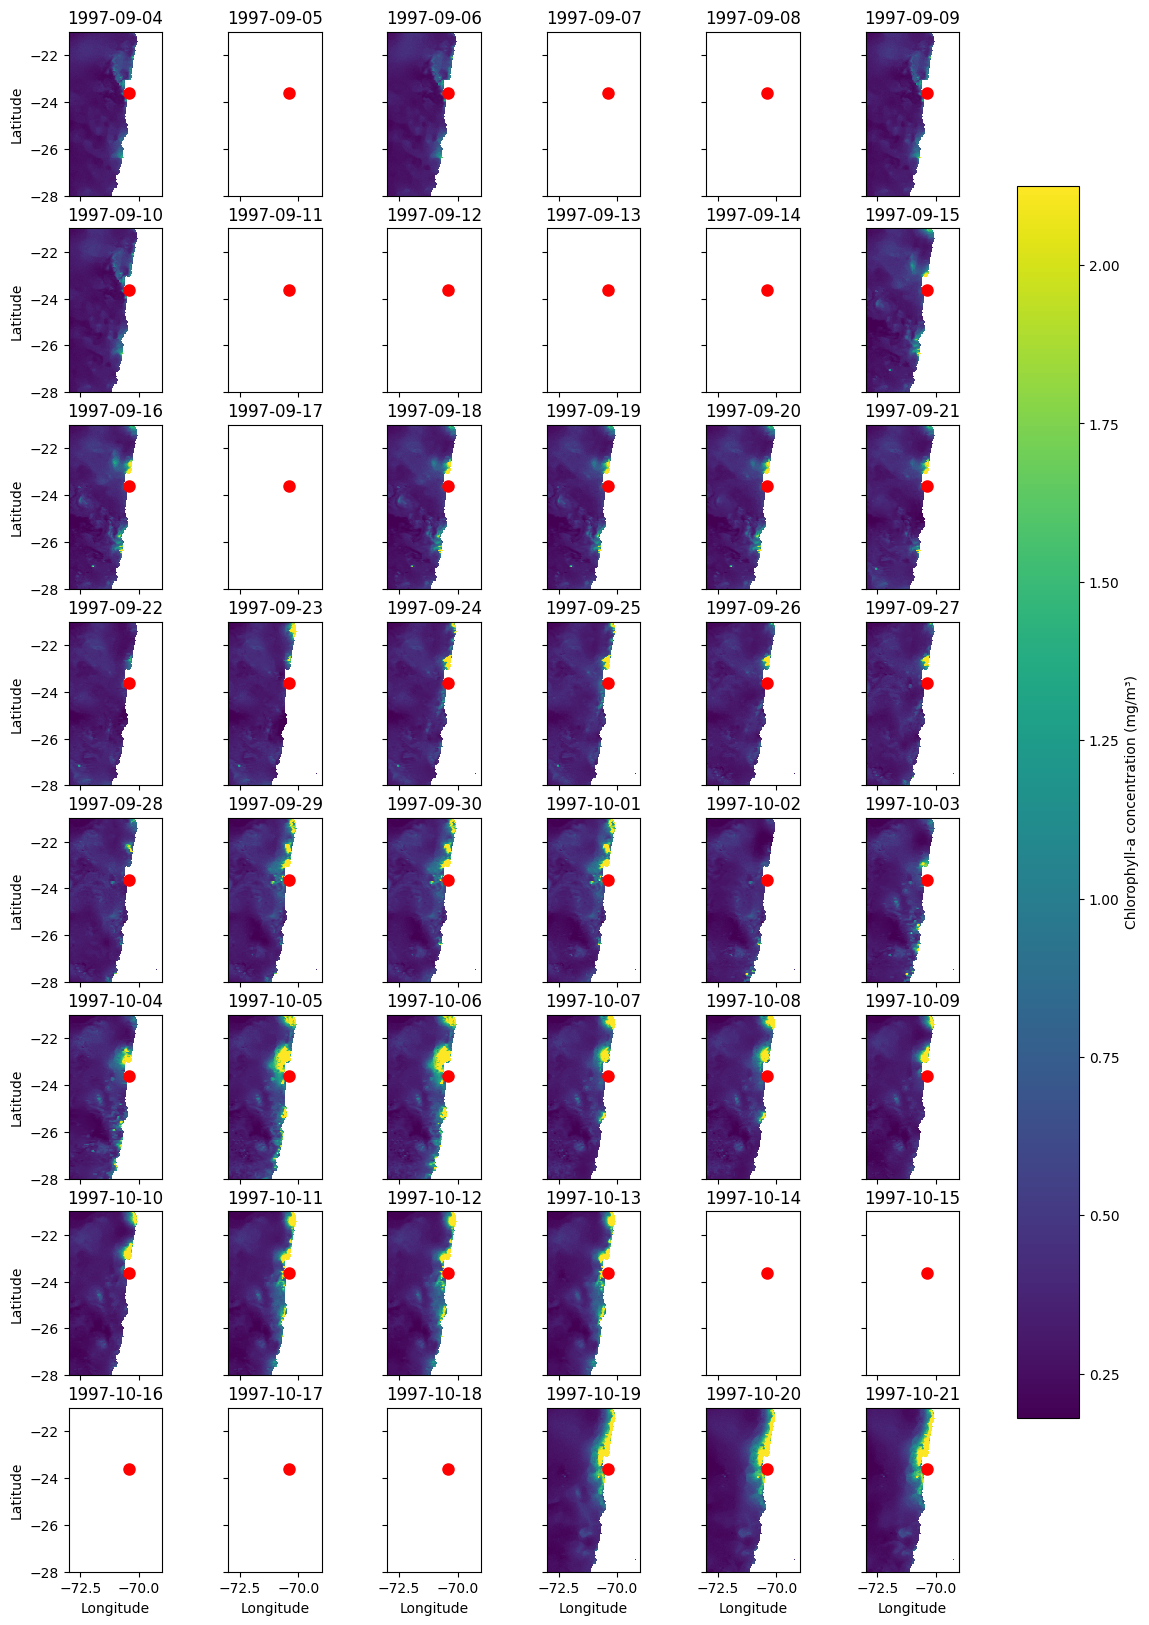

In [9]:
def plot_chlorophyll_grid(
    ds: xr.Dataset,
    n_row: int = 8,
    n_col: int = 6,
    titles: list[str] | None = None,
    figsize: tuple[int, int] = (15, 20),
) -> tuple[Figure, Axes]:
    """
    Plot a grid of the first n_row * n_col chlorophyll-a concentration images
    from a dataset.

    :param ds: xarray dataset containing chlorophyll-a data.
    :param n_row: Number of rows in the grid. Default is 8.
    :param n_col: Number of columns in the grid. Default is 6.
    :return: Tuple of the figure and axes objects.
    """

    if titles is not None:
        assert len(titles) == n_row * n_col, "Number of titles must match grid size."

    fig, axs = plt.subplots(n_row, n_col, figsize=figsize)

    ds = ds.sel(time=ds.time[: n_row * n_col])
    q_01, q_99 = ds["CHL"].quantile([0.01, 0.99], method="closest_observation").values

    for i, j in product(range(n_row), range(n_col)):
        time_index = i * n_col + j

        title = (
            titles[time_index] if titles else f"{str(ds.time[time_index].values)[:10]}"
        )

        plot_chlorophyll(
            ds,
            time_index,
            fig,
            axs[i, j],
            colorbar=False,
            title=title,
            vmin=q_01,
            vmax=q_99,
        )

        if j != 0:
            axs[i, j].set_ylabel("")
            axs[i, j].set_yticklabels([])

        if i != n_row - 1:
            axs[i, j].set_xlabel("")
            axs[i, j].set_xticklabels([])

    cbar = fig.colorbar(
        axs[0, 0].collections[0],
        ax=axs[:, :],
        label="Chlorophyll-a concentration (mg/m³)",
        location="right",
        shrink=0.8,
    )
    cbar.cmap.set_under("gray")
    cbar.cmap.set_over("magenta")

    return fig, axs


plot_chlorophyll_grid(ds, n_row=8, n_col=6)
plt.show()

The grid plot confirms that sporadic missing data exists over the ocean area at various times. To analyze the temporal pattern of missingness, we select a specific coordinate within the ocean and examine its time series.

In [10]:
chl_da = ds["CHL"].sel(lat=-24, lon=-72, method="nearest")
chl_np = chl_da.values

In [11]:
# Let's check the number of NaN values in the array
print(
    f"Number of NaN values: {int(np.isnan(chl_np).sum())} / {chl_np.size} "
    f"({float(np.isnan(chl_np).sum() / chl_np.size * 100):.2f}%)"
)

Number of NaN values: 24 / 9842 (0.24%)


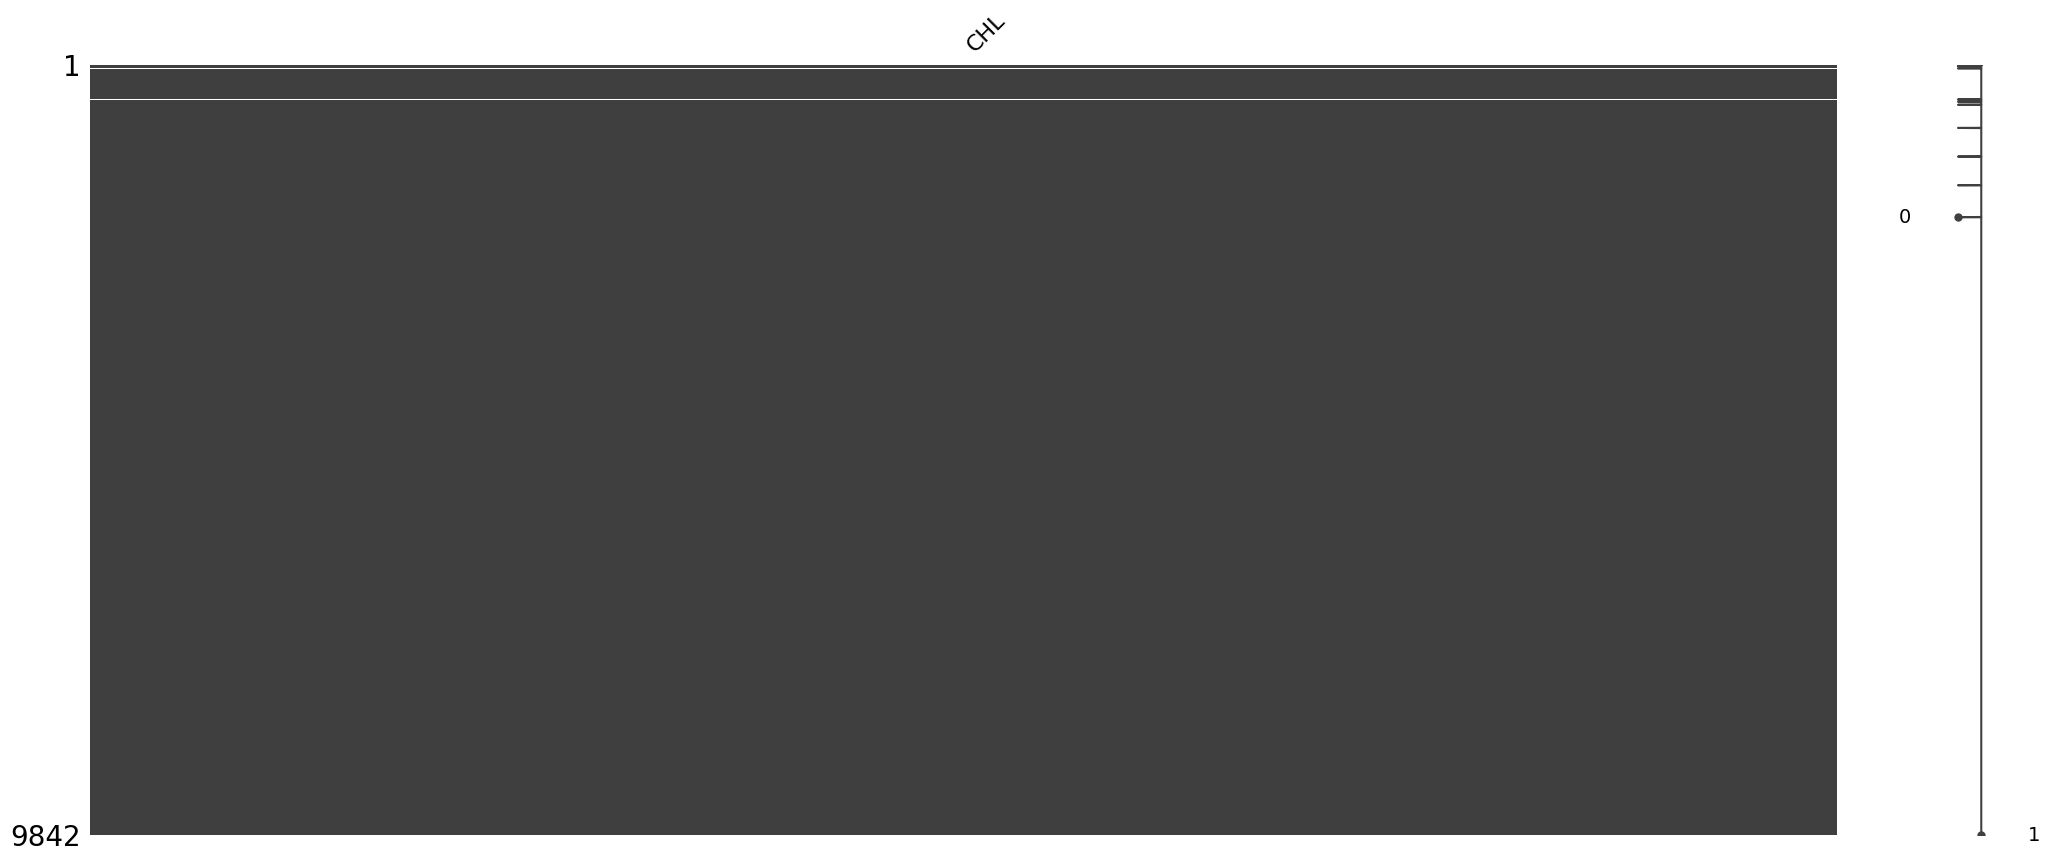

In [12]:
df = pd.DataFrame({"CHL": chl_np})

msno.matrix(df)
plt.show()

The missingness matrix indicates that most missing values occur at the beginning of the time series. A zoomed-in view will provide more detail.

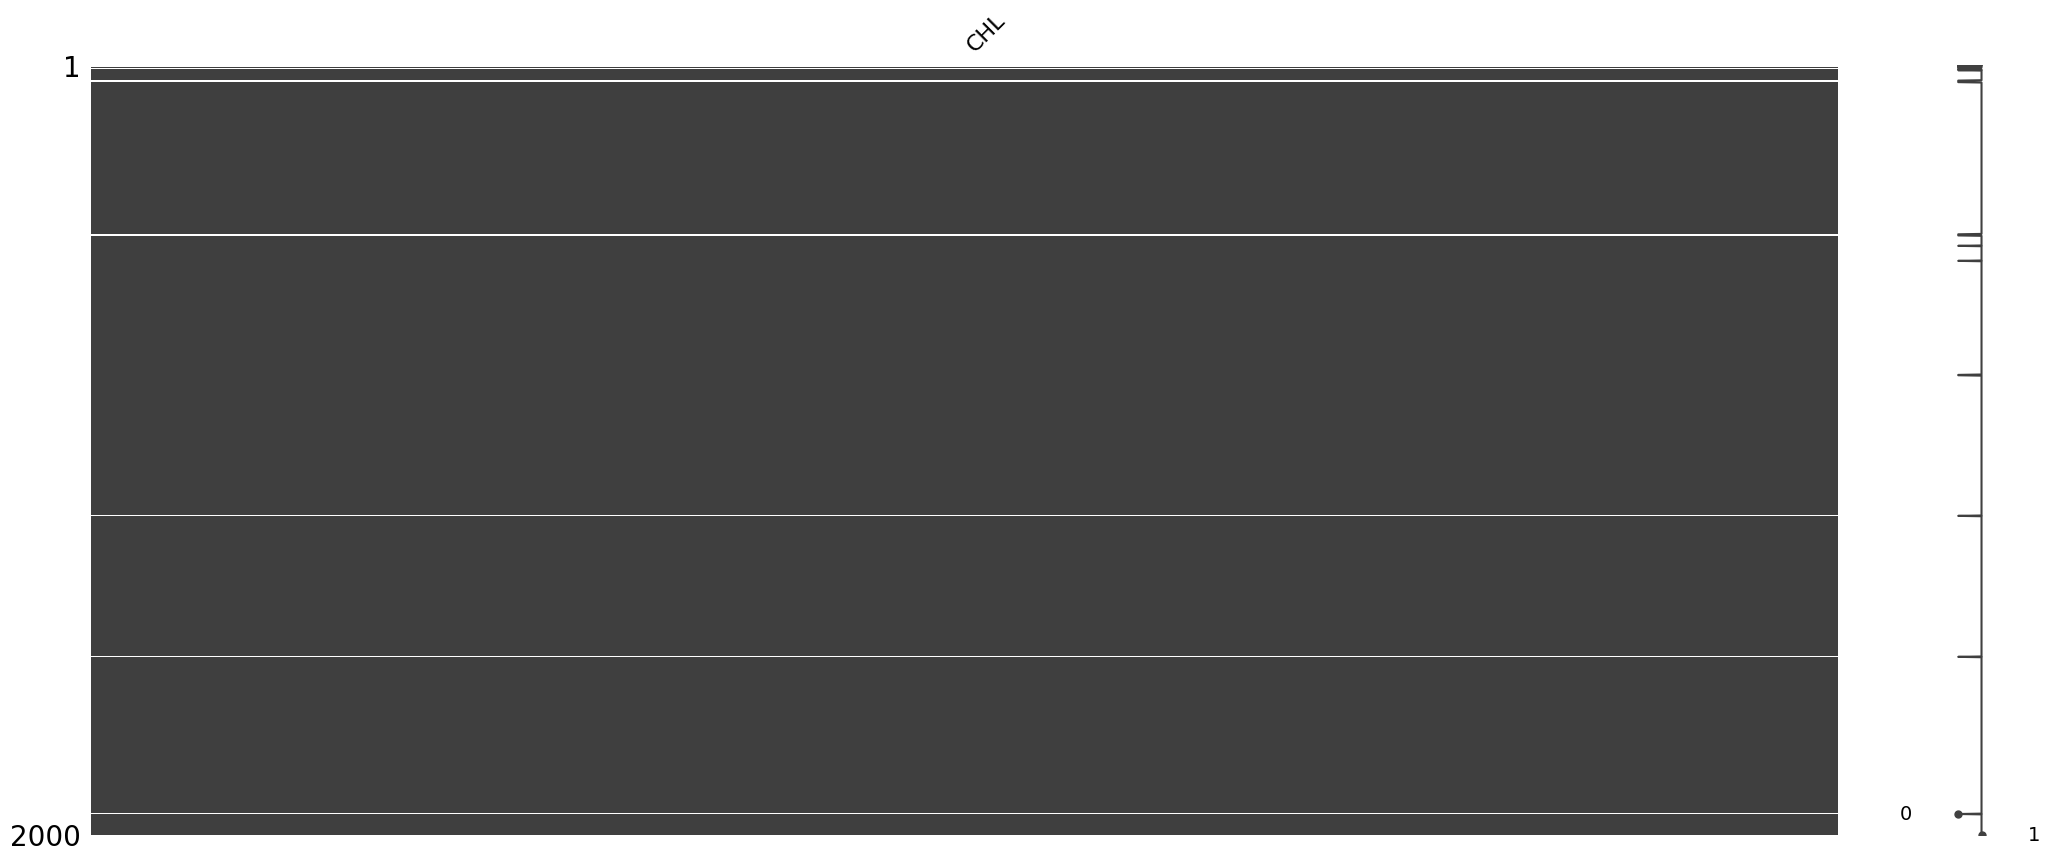

In [13]:
msno.matrix(df[:2000])
plt.show()

It can be seen that over the time series there are 24 occasions where there is no data. This may be due to the presence of clouds at the time of image acquisition.

In this case, since there are so few missing values, the values can be interpolated. For the sake of speed and simplicity, linear interpolation will be used. If this is found to affect the result, one can switch to a more robust interpolation, such as spline or linear RBF, albeit sacrificing more computational time for such a small amount of data.

Furthermore, one could use the methods mentioned in the paper [Ferreira, 2021](https://doi.org/10.3390/rs13040675), which mention the 3-step gap-filling algorithm [Sasaoka, 2011](https://doi.org/10.1016/j.rse.2014.05.016), and the 3-week centred moving mean algorithm [Ferreira, 2014](https://doi.org/10.1002/2014JC010323). These methods could be implemented in the future to improve the analysis.

## Missing Data Handling

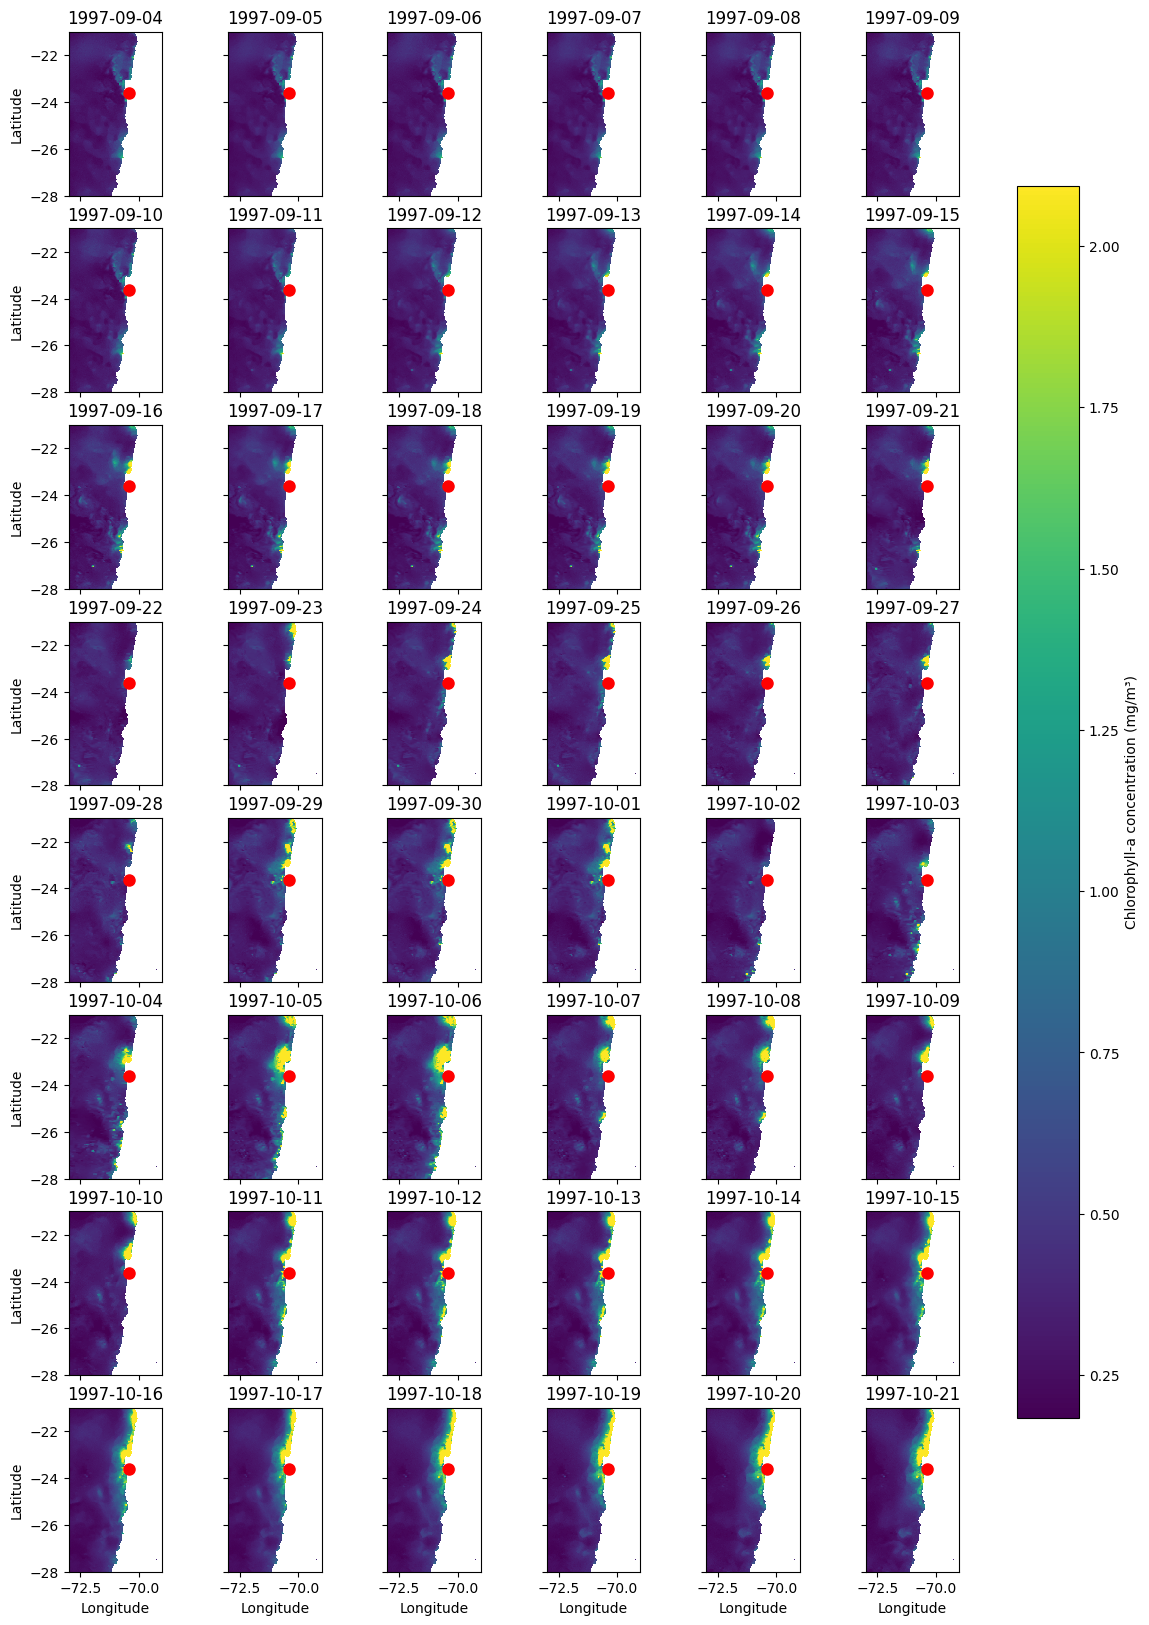

In [14]:
# interpolate nan
ds = ds.interpolate_na(dim="time", method="linear")

plot_chlorophyll_grid(ds, n_row=8, n_col=6)
plt.show()

Additionally, the coastal region, identified by persistent missing values (NaNs) even after temporal interpolation, is removed as it is not relevant to the oceanic chlorophyll analysis.

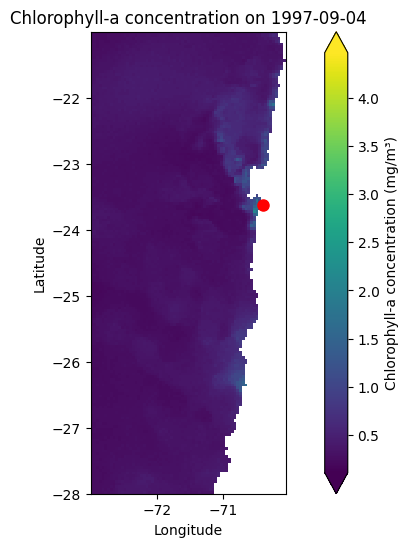

In [15]:
lon_max = ds.lon.where(~np.isnan(ds.CHL[0, :, :])).max()

ds = ds.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

plot_chlorophyll(ds, 0)
plt.show()

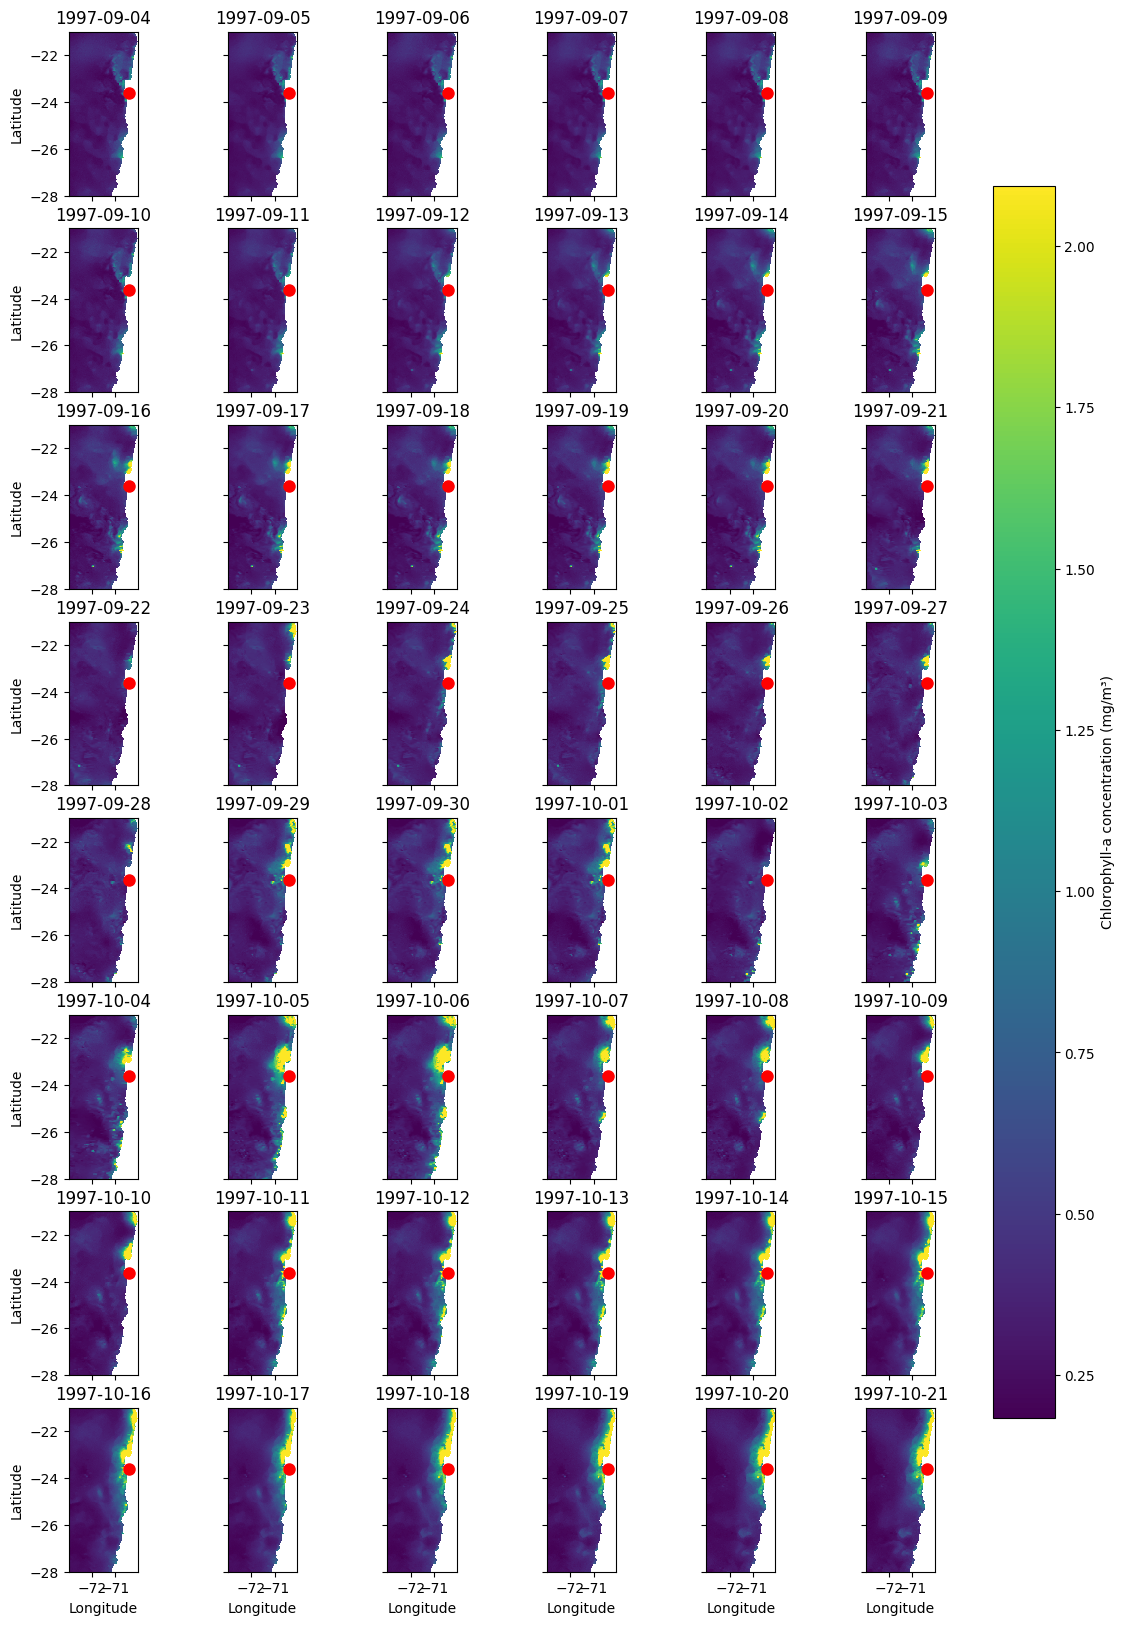

In [16]:
plot_chlorophyll_grid(ds, n_row=8, n_col=6)
plt.show()

Finally, any remaining null values, primarily located in the persistent coastal region identified earlier, must be handled. 

These cannot be interpolated reliably (as they likely represent land or very shallow/complex waters not captured well by the dataset resolution) and filling them with arbitrary values could lead to erroneous conclusions. Therefore, a spatial mask is created to identify valid ocean pixels for analysis.

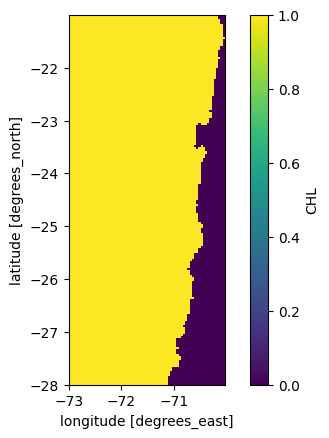

In [17]:
mask = ds.CHL.notnull().all(dim="time")
fig, ax = plt.subplots()

mask.plot()
ax.set_aspect("equal", adjustable="box")

# Exploratory Data Analysis

> How is chlorophyll-a distributed spatially and temporally throughout the year in the study region?

To address this, we will compute and visualize the average monthly and seasonal chlorophyll-a concentrations for each year in the dataset. This will help identify typical patterns and variations.

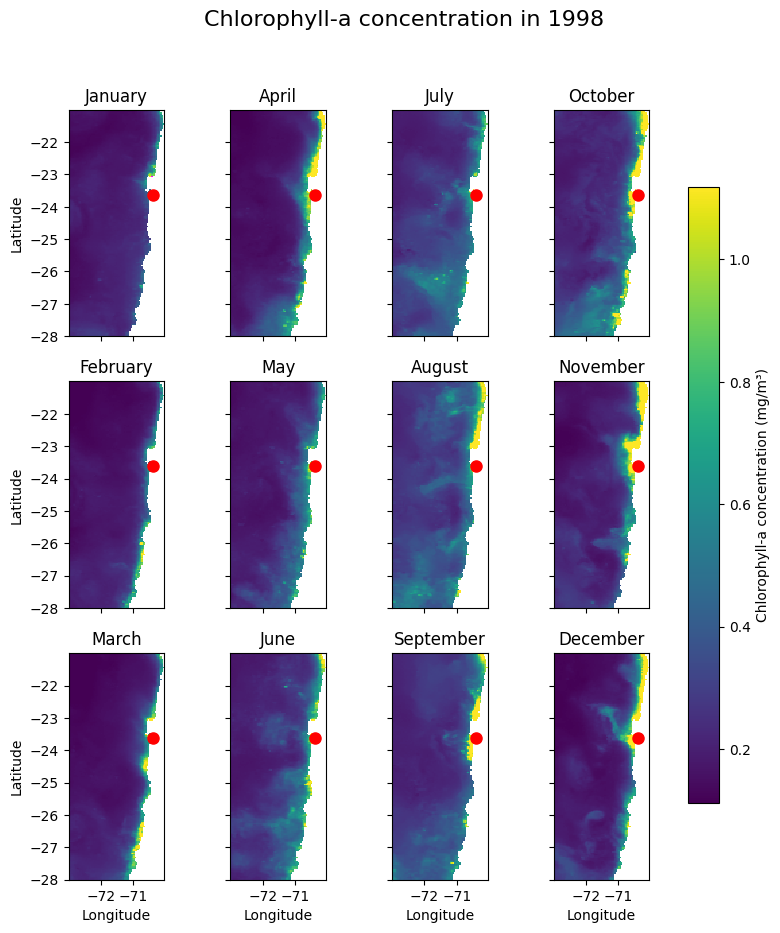

In [18]:
def plot_chlorophyll_yearly(
    ds: xr.Dataset, year: str
) -> tuple[Figure, np.ndarray[Axes]]:
    """
    Plot a 12 months average chlorophyll-a concentration from a dataset.

    :param ds: xarray dataset containing chlorophyll-a data.
    :param year: Year to plot. Must be a string in the format "YYYY".
    :return: Tuple of the figure and axes objects.
    """

    ds_ = ds.sel(time=slice(f"{year}-01-01", f"{year}-12-31"))
    ds_ = ds_.resample(time="ME").mean()

    # fmt: off
    months_names = [
        "January", "February", "March", "April", "May", "June", "July", 
        "August", "September", "October", "November", "December",
    ]
    # fmt: on

    # To visually group the months by seasons
    rearrange = [0, 3, 6, 9, 1, 4, 7, 10, 2, 5, 8, 11]
    months_names = [months_names[i] for i in rearrange]
    ds_ = ds_.isel(time=rearrange)

    fig, axs = plot_chlorophyll_grid(
        ds_, n_row=3, n_col=4, titles=months_names, figsize=(10, 10)
    )
    fig.suptitle(f"Chlorophyll-a concentration in {year}", fontsize=16)

    return fig, axs


plot_chlorophyll_yearly(ds, "1998")
plt.show()

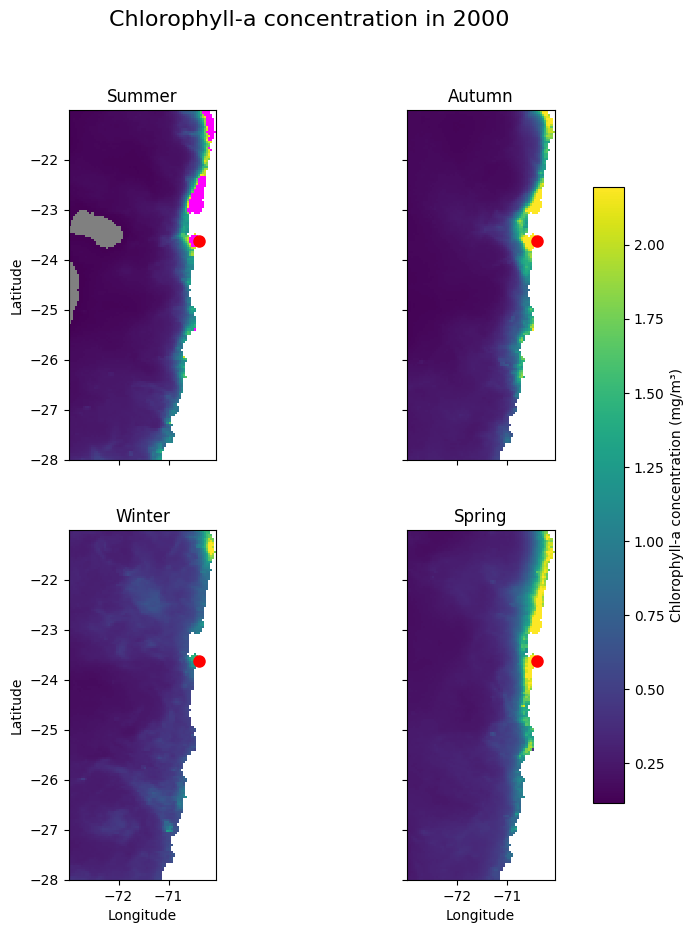

In [19]:
def plot_chlorophyll_seasonly(
    ds: xr.Dataset, year: str
) -> tuple[Figure, np.ndarray[Axes]]:
    """
    Plot the 4 seasons in a year.

    :param ds: xarray dataset containing chlorophyll-a data.
    :param year: Year to plot. Must be a string in the format "YYYY".
    :return: Tuple of the figure and axes objects.
    """

    ds_ = ds.sel(time=slice(f"{int(year)-1}-12-21", f"{year}-12-21"))
    ds_ = ds_.resample(time="3MS").mean()

    season_names = ["Summer", "Autumn", "Winter", "Spring"]

    fig, axs = plot_chlorophyll_grid(
        ds_, n_row=2, n_col=2, titles=season_names, figsize=(10, 10)
    )
    fig.suptitle(f"Chlorophyll-a concentration in {year}", fontsize=16)

    return fig, axs


plot_chlorophyll_seasonly(ds, "2000")
plt.show()

Generating these plots for each year allows for the observation of inter-annual variability, consistent patterns, and potential anomalies or trends over the study period.

In [ ]:
year_init, year_end = 2023, 2024
year_init, year_end = 1998, 2024

PATH_PLOT_CHL_YEARLY = IMG_PATH / "chl_yearly"
PATH_PLOT_CHL_SEASONLY = IMG_PATH / "chl_seasonly"
PATH_PLOT_CHL_YEARLY.mkdir(parents=True, exist_ok=True)
PATH_PLOT_CHL_SEASONLY.mkdir(parents=True, exist_ok=True)


# If any option (save or show plots) are eneabled, then run this code
if SAVE_PLOTS or SHOW_PLOTS:

    # Charging bar
    iterable = range(year_init, year_end)

    if not SHOW_PLOTS:
        iterable = tqdm(iterable, desc="Saving plots")

    for year in iterable:
        fig_y, _ = plot_chlorophyll_yearly(ds, str(year))
        fig_s, _ = plot_chlorophyll_seasonly(ds, str(year))

        if SAVE_PLOTS:
            filepath_y = PATH_PLOT_CHL_YEARLY / f"chl_yearly_{year}.png"
            fig_y.savefig(filepath_y, bbox_inches="tight")

            filepath_s = PATH_PLOT_CHL_SEASONLY / f"chl_seasonly_{year}.png"
            fig_s.savefig(filepath_s, bbox_inches="tight")

        if SHOW_PLOTS:
            plt.show()
        else:
            plt.close(fig_s)
            plt.close(fig_y)

Saving plots: 100%|██████████| 26/26 [00:43<00:00,  1.66s/it]


The exploratory analysis reveals distinct seasonal patterns in chlorophyll-a concentrations within the study area off the coast of Chile. The highest concentrations consistently occur during the warmer Southern Hemisphere seasons, primarily spring and summer (approximately September to March).

Peak concentrations are typically observed in January, often reaching or exceeding the 99th percentile of the dataset's distribution (visualized as magenta in the plots). Given that chlorophyll-a serves as a proxy for phytoplankton biomass, these findings strongly indicate heightened phytoplankton activity during Chile's warmer months.

Overall, significant chlorophyll-a levels are characteristic from early spring (September) through late autumn (May). Furthermore, a visual inspection of the yearly plots suggests a potential upward trend in the *maximum* observed chlorophyll-a concentrations over the analyzed years, warranting further investigation in the time series analysis.

# Time Series Analysis

Firstly, we will seek to extract the time series for the region of interest. This time series will be constructed from the mean, and will be done for the daily, monthly and annual evolution, averaging the values for each month and year. Additionally, a region of interest will be selected around the point of interest.

In [21]:
delta = 2
lon_min_sel, lon_max_sel = LON_POI - delta, LON_POI + delta
lat_min_sel, lat_max_sel = LAT_POI - delta, LAT_POI + delta
lon_min_sel = -71.5  # Cut the left side
ds = ds.sel(lon=slice(lon_min_sel, lon_max_sel), lat=slice(lat_min_sel, lat_max_sel))

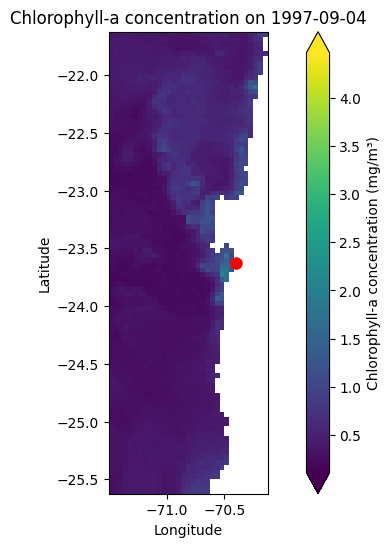

In [22]:
lon_max = ds.lon.where(~np.isnan(ds.CHL[0, :, :])).max()

ds = ds.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

plot_chlorophyll(ds, 0)
plt.show()

## Time Series Extraction

In [23]:
# Daily mean chlorophyll-a concentration
mean_chl_daily = ds.CHL.mean(dim=("lat", "lon"))

# Monthly mean chlorophyll-a concentration
mean_chl_monthly = ds.CHL.resample(time="1ME").mean().mean(dim=("lat", "lon"))

# Yearly mean chlorophyll-a concentration
mean_chl_yearly = ds.CHL.resample(time="1YE").mean().mean(dim=("lat", "lon"))

In [24]:
def ds_to_df(ds: xr.Dataset, name: str, freq: str) -> pd.DataFrame:
    """
    Convert an xarray dataset to a pandas DataFrame time series.

    :param ds: xarray dataset to convert.
    :param name: Name of the DataFrame's column.
    :param freq: Frequency to resample the data. Must be a valid pandas frequency string.
    :return: Pandas DataFrame with the data from the xarray dataset.
    """
    df: pd.DataFrame = ds.to_dataframe(name=name)

    df.reset_index(inplace=True)
    df.set_index("time", inplace=True)

    return df

## Time Series Decomposition

The time series decomposition is performed using the `statsmodels` library, which provides a convenient way to decompose time series data into its trend, seasonal, and residual components. The decomposition is done using the `seasonal_decompose` function, which applies the classical additive or multiplicative decomposition method.

In [25]:
mean_df_daily = ds_to_df(mean_chl_daily, "mean_chl_daily", "D")
mean_df_monthly = ds_to_df(mean_chl_monthly, "mean_chl_monthly", "ME")
mean_df_yearly = ds_to_df(mean_chl_yearly, "mean_chl_yearly", "YE")

In [26]:
import statsmodels.tsa.seasonal as sm_seasonal


def plot_seasonal_decompose(
    ts: pd.Series,
    period: int,
    model: str = "additive",
    range_: tuple[int, int] | None = None,
    title: str | None = None,
) -> tuple[sm_seasonal.DecomposeResult, Figure]:
    """
    Decompose a time series into trend, seasonal, and residual components.

    :param ts: Time series to decompose.
    :param period: Period of the seasonal component. Default is 12 for monthly data.
    :param model: Type of decomposition model. Can be 'additive' or 'multiplicative'.
    :param range_: Range of the time series to plot. Default is None (full range).
    :return: Tuple of the decomposition result and the figure object.
    """
    if range_ is not None:
        ts = ts[range_[0] : range_[1]]

    result = sm_seasonal.seasonal_decompose(ts, model=model, period=period)

    fig = result.plot()

    if title is not None:
        # Remove the title from the first axes
        axes = fig.get_axes()
        axes[0].set_title("")

        # Set the title for the entire figure
        fig.suptitle(title, fontsize=12)

    return result, fig

In [27]:
SEASONAL_DECOMPOSE_PATH = IMG_PATH / "seasonal_decompose"
SEASONAL_DECOMPOSE_PATH.mkdir(parents=True, exist_ok=True)


# (title name, name, time series, period)
time_series_list = [
    (
        "Daily mean chlorophyll-a concentration",
        "mean_daily",
        mean_df_daily["mean_chl_daily"],
        365,
    ),
    (
        "Monthly mean chlorophyll-a concentration",
        "mean_monthly",
        mean_df_monthly["mean_chl_monthly"],
        12,
    ),
    (
        "Yearly mean chlorophyll-a concentration",
        "mean_yearly",
        mean_df_yearly["mean_chl_yearly"],
        None,
    ),
]


if SAVE_PLOTS or SHOW_PLOTS:
    for title, name, ts, period in time_series_list:
        result, fig = plot_seasonal_decompose(
            ts, period=period, model="additive", title=title
        )

        if SAVE_PLOTS:
            fig.savefig(
                SEASONAL_DECOMPOSE_PATH / f"seasonal_decompose_{name}.png",
                bbox_inches="tight",
            )

        if SHOW_PLOTS:
            plt.show()
        else:
            plt.close(fig)

From the generated plots, it is evident that there was an upward trend from 1998 to 2003. This trend remained relatively stable until 2022, when there was an abrupt decrease.

The seasonality has been consistent over time, oscillating between values of 0.3 and -0.25, though this may be attributable to the time window employed for the analysis. To verify this, a decomposition of the time series with different time windows will be conducted.

Finally, it is observed that the residual of the time series presents a high degree of variability, far exceeding the trend and seasonality values. This may indicate a high degree of variability in the time series, which could hinder the identification of long-term patterns and trends. However, it is important to note that this variability may also be the result of external factors, such as climatic changes or natural events, which can affect the chlorophyll concentration in the ocean.

## Time Series Decomposition with Different Time Windows

In [28]:
def plot_seasonal_decompose_range(
    ts_daily: pd.Series,
    ts_monthly: pd.Series,
    year_range: tuple[int, int],
) -> None:
    """
    Plot the seasonal decomposition for daily and monthly time series.

    :param ts_daily: Daily time series to decompose.
    :param ts_monthly: Monthly time series to decompose.
    :param year_range: Range of years to plot. Must be a tuple of two integers.
    :return: None
    """

    year_init, year_end = year_range

    range_daily = ((year_init - 1998) * 365, (year_end - 1998 + 1) * 365)
    range_monthly = ((year_init - 1998) * 12, (year_end - 1998 + 1) * 12)

    title = f"Daily mean chlorophyll-a concentration, period range: {year_init} - {year_end}"
    plot_seasonal_decompose(
        ts_daily, period=365, model="additive", range_=range_daily, title=title
    )
    plt.show()

    title = f"Monthly mean chlorophyll-a concentration, period range: {year_init} - {year_end}"
    plot_seasonal_decompose(
        ts_monthly, period=12, model="additive", range_=range_monthly, title=title
    )
    plt.show()

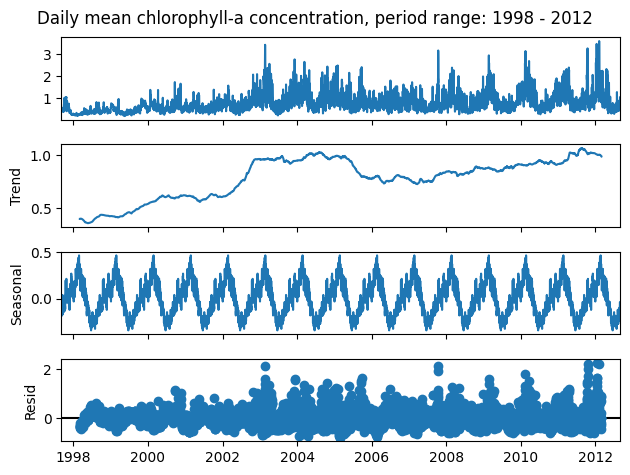

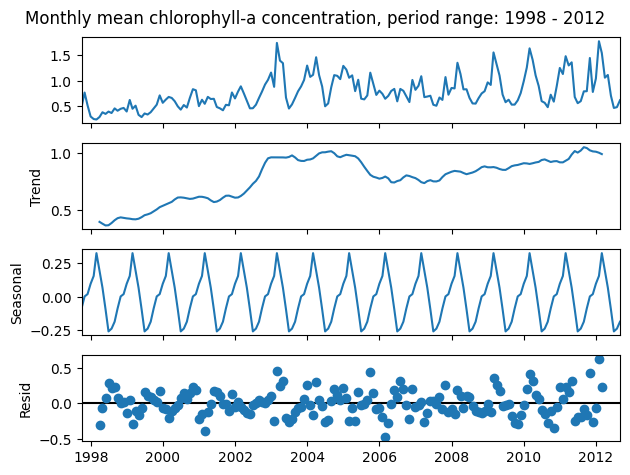

In [29]:
plot_seasonal_decompose_range(
    mean_df_daily["mean_chl_daily"], mean_df_monthly["mean_chl_monthly"], (1998, 2012)
)

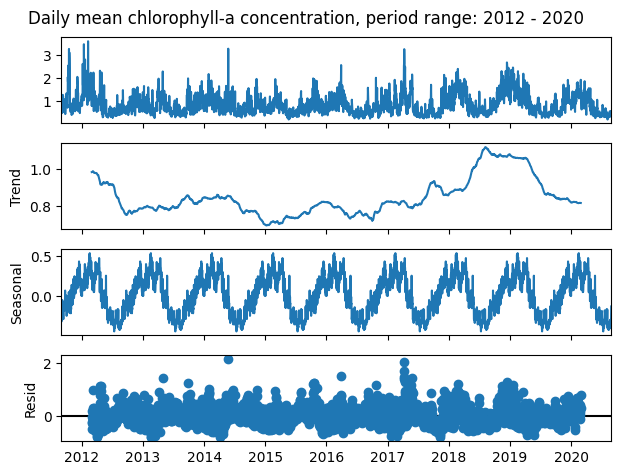

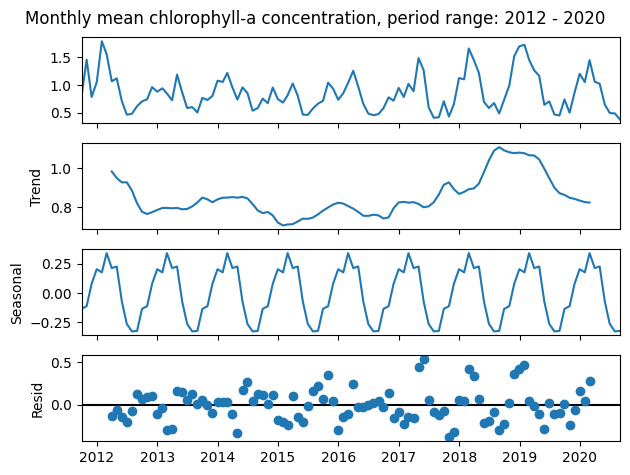

In [30]:
plot_seasonal_decompose_range(
    mean_df_daily["mean_chl_daily"], mean_df_monthly["mean_chl_monthly"], (2012, 2020)
)

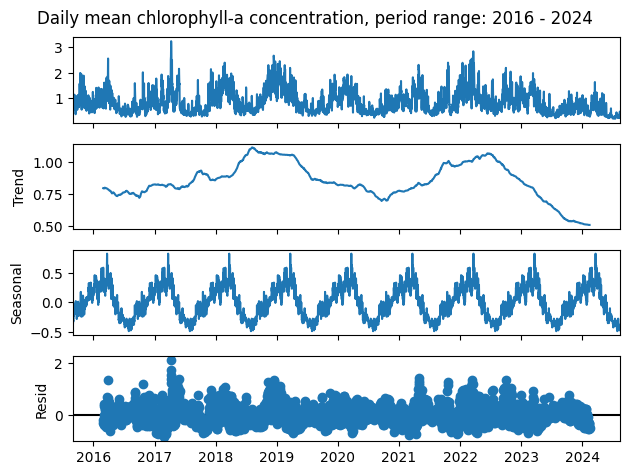

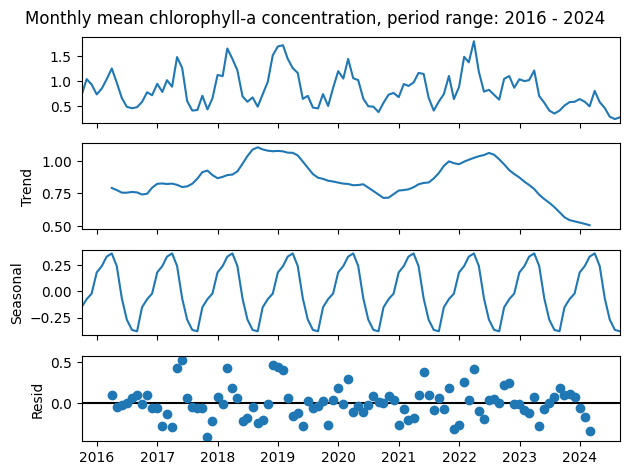

In [31]:
plot_seasonal_decompose_range(
    mean_df_daily["mean_chl_daily"], mean_df_monthly["mean_chl_monthly"], (2016, 2024)
)

The time series were plotted in the ranges 2004-2012, 2012-2020 and 2016-2024.

A key finding is the variation in the range of values that the seasonal component moves within these ranges. It is observed that the seasonality remains within the range of 0.5 to -0.5. However, the residuals continue to exhibit notably high values, particularly in terms of trend and seasonality. 

It is observed that the trend has similar values to the full range decomposition.

# Spatial Analysis

In this section, we will analyse the spatial distribution of chlorophyll over time. To do so, the metrics outlined in the paper by Ferreira et al. (2021) will be calculated and the results plotted. The metrics to be calculated are as follows:

| **Metric** | **Full Name**        | **Unit**         | **Description**                                                  |
|------------|----------------------|------------------|------------------------------------------------------------------|
| Mean       | Chl *a* mean         | mg m⁻³           | Mean Chl *a* concentration of the seasonal cycle                |
| Max        | Chl *a* maximum      | mg m⁻³           | Maximum Chl *a* concentration of the seasonal cycle             |
| BAmp       | Bloom amplitude      | mg m⁻³           | Difference between Chl *a* maximum and mean                     |
| BPeak      | Bloom peak           | -                | DOY of Chl *a* Maximum                                          |
| BInit      | Bloom initiation     | -                | DOY of initiation of the main bloom in the seasonal cycle       |
| BTerm      | Bloom termination    | -                | DOY of termination of the main bloom in the seasonal cycle      |
| BDur       | Bloom duration       | days             | Duration of the main bloom in the seasonal cycle                |
| BArea      | Bloom area           | mg m⁻³           | Biomass of the main bloom in the seasonal cycle                 |
| YArea      | Yearly area          | mg m⁻³           | Total biomass accumulated during the seasonal cycle             |
| BFreq      | Bloom Frequency      | blooms year⁻¹    | Number of blooms in the seasonal cycle                          |


In [32]:
# Select the time range from 1998 to the end of the dataset
ds = ds.sel(time=slice("1998-01-01", None))

## Mean Chlorophyll-a Concentration

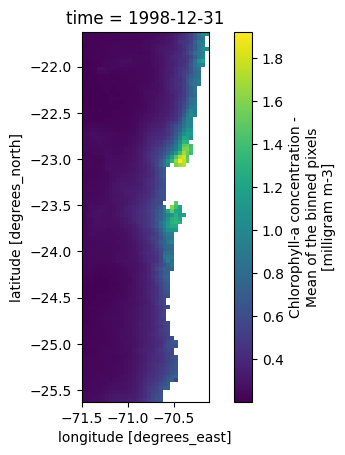

In [33]:
chl_mean = ds.resample(time="1YE").mean()
chl_mean["CHL"][0].plot()
plt.gca().set_aspect("equal")

## Maximum Chlorophyll-a Concentration

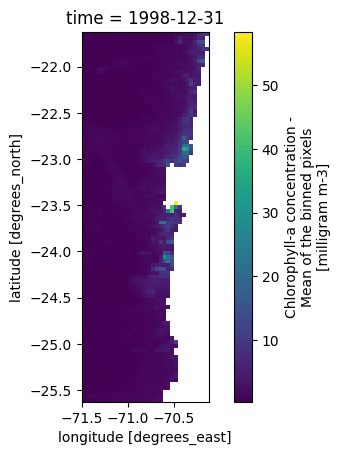

In [34]:
chl_max = ds.resample(time="1YE").max()
chl_max["CHL"][0].plot()
plt.gca().set_aspect("equal")

## Bloom Amplitude

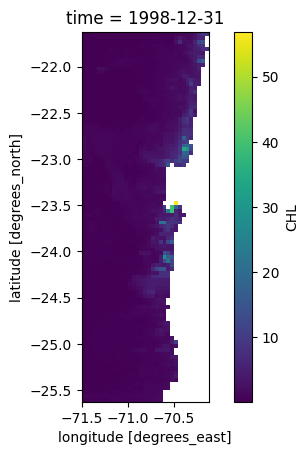

In [35]:
b_amp = chl_max - chl_mean
b_amp["CHL"][0].plot()
plt.gca().set_aspect("equal")

## Bloom Initiation

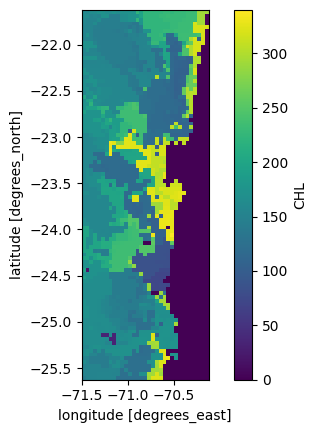

In [36]:
def compute_bloom_initiation(ds: xr.Dataset, year: int) -> xr.Dataset:
    """
    Compute the bloom inition day of year for a year.

    Specifically, the first day when Chl-a rises above a threshold (5% above annual median) and stays there for at least 15 days.

    :param ds: xarray dataset containing chlorophyll-a data.
    :param year: Year to compute the bloom initiation for. Must be an integer.
    :return: xarray dataset with the bloom initiation day of year.
    """

    chl = ds.CHL.sel(time=slice(f"{year}-01-01", f"{year}-12-31"))

    # Chl-a median.
    chl_median = chl.resample(time="1YE").median()  # Dimensions (time=1, lat, lon)
    threshold = chl_median * 1.05
    threshold = threshold[0]  # Dimensions (lat, lon)

    # Threshold mask. Dimensions (time, lat, lon)
    threshold_expanded = threshold.broadcast_like(chl)

    # Values above threshold. Dimensions (time, lat, lon)
    above_threshold = chl > threshold_expanded

    # Number of days above threshold. Dimensions (time, lat, lon)
    rolling_sum = above_threshold.rolling(time=15, center=False).sum()

    # Bloom mask. Dimensions (time, lat, lon)
    bloom_mask = rolling_sum >= 15

    b_init = bloom_mask.argmax(dim="time")

    return b_init


compute_bloom_initiation(ds, 1998).plot()
plt.gca().set_aspect("equal")